In [1]:
import sys
sys.path.append('../src')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf
from gait.config import pd
from gait.utils import get_data_by_overlap_percent,get_overlap_data_all_sessions,  split_test_train_by_subjects, remove_invalid_data, get_overlap_data_all_sessions
from gait.training import train_model_with_stats, build_cnn_stats_small
from gait.evalution import save_history, save_test_history, save_accuracy_loss_figure, save_confusion_matrix_figure, compute_validations_predictions,compute_validations_predictions_with_stats,compute_validations_predictions_cnn_multihead_with_stats

In [2]:
model = build_cnn_stats_small(128, 12, 5, np.ones((9, 12)))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 12, 4)   52          ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 12, 4)  16          ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                              

In [3]:
def compute_resultant_acceleration(X):
    return np.sqrt(X[:,:,0] **2 + X[:,:,1] ** 2 + X[:,:,2] ** 2)

def compute_resultant_gyro(X):
    return np.sqrt(X[:,:,3] **2 + X[:,:,4] ** 2 + X[:,:,5] ** 2)

def compute_resultant_angle(X):
    return np.sqrt(X[:,:,6] **2 + X[:,:,7] ** 2 + X[:,:,8] ** 2)

def get_std_values(X, channel):
    return np.std(X[:, :, channel], axis=1)

def get_mean_values(X, channel):
    return np.mean(X[:, :, channel], axis=1)

def get_max_values(X, channel):
    return np.max(X[:, :, channel], axis=1)

def get_median_values(X, channel):
    return np.median(X[:, :, channel], axis=1)


def get_statistic_feature_all_channels(X):
    statistic_features = []
    for channel in range(9,12):
        statistic_features.append(get_std_values(X, channel))
        statistic_features.append(get_mean_values(X, channel))
        statistic_features.append(get_max_values(X, channel))
        statistic_features.append(get_median_values(X, channel))

    return np.vstack(statistic_features).T

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Statistic feature shape:  (108973, 12)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Red

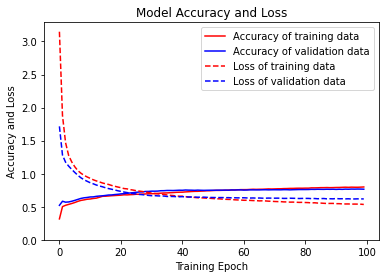

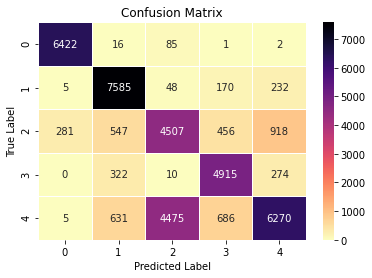

In [4]:
overlapPercents = [90]
# overlapPercents = [0]
# exclude_subjects = ['ddAeJA42PXvwthbW', 'nan', 'LLZjAPTyj7muHsEf',
#                     'MMuX9YIh4NTbLZLM', 'cbOZWnI7s1y8oLD4', 'PE8D53oX060qLbdX', 'xYdtS1F8tDyjEIgN', 'sUZBISq61Y7I5tqQ']
exclude_subjects = ['ddAeJA42PXvwthbW', 'nan',
                    'MMuX9YIh4NTbLZLM',
                    'NKdnm6cN3KKAx7R4',
                    'PE8D53oX060qLbdX',
                    'xYdtS1F8tDyjEIgN',
                    'EUbKPOSQgjccjtvi',
                    'PE8D53oX060qLbdX',
                    'ddAeJA42PXvwthbW',
                    'LLZjAPTyj7muHsEf',
                    'cbOZWnI7s1y8oLD4',
                    'ddAeJA42PXvwthbW',
                    '1ZstYhEKzKKfGnMW',
                    'LLZjAPTyj7muHsEf',
                    'bQsRwKxgJiXTzo6P',
                    'sUZBISq61Y7I5tqQ',
                    '19AoxD1bgrDckd2p',
                    'wtyNo4LYaWXrkzA7',
                    ]

for OVERLAP_PERCENT in overlapPercents:
    gpus = tf.config.list_logical_devices('GPU')
    strategy = tf.distribute.MirroredStrategy(gpus)
    with strategy.scope():
        X, y, subjects = get_overlap_data_all_sessions(OVERLAP_PERCENT)
        # REMOVE UNWANTED SUBJECTS
        indexes = np.where(subjects == exclude_subjects)
        X = np.delete(X, indexes[0], axis=0)
        y = np.delete(y, indexes[0], axis=0)
        subjects = np.delete(subjects, indexes[0], axis=0)
        # END REMOVE UNWANTED SUBJECTS

        # AUGMENT DATA
        resultant_acc = compute_resultant_acceleration(X)
        resultant_gyro = compute_resultant_gyro(X)
        resultant_angle = compute_resultant_angle(X)
        resultant_acc = resultant_acc.reshape(
            resultant_acc.shape[0], resultant_acc.shape[1], 1)
        resultant_gyro = resultant_gyro.reshape(
            resultant_gyro.shape[0], resultant_gyro.shape[1], 1)
        resultant_angle = resultant_angle.reshape(
            resultant_angle.shape[0], resultant_angle.shape[1], 1)
        X = np.concatenate((X, resultant_acc), axis=2)
        X = np.concatenate((X, resultant_gyro), axis=2)
        X = np.concatenate((X, resultant_angle), axis=2)
        # AUGMENT DATA END

        # print('UNIQUE subjects:', np.unique(subjects))
        X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
            X, y, subjects, train_percent=0.8)
        X_train_stats = get_statistic_feature_all_channels(X_train)
        X_test_stats = get_statistic_feature_all_channels(X_test)
        print('Statistic feature shape: ', X_train_stats.shape)
        model, history = train_model_with_stats(
            X_train, y_train, X_test, y_test, X_train_stats, X_test_stats, overlap_percent=OVERLAP_PERCENT, batch_size=128, epochs=100)

        save_history(history, OVERLAP_PERCENT)
        evaluation_history = model.evaluate(
            [X_test, X_test_stats], y_test, batch_size=128, verbose=1)
        save_test_history(evaluation_history, OVERLAP_PERCENT)
        save_accuracy_loss_figure(history, OVERLAP_PERCENT)
        validations, predictions = compute_validations_predictions_with_stats(
            model, X_test, y_test, X_test_stats)
        save_confusion_matrix_figure(
            validations, predictions, OVERLAP_PERCENT, sns)


In [26]:
model.save('final')

INFO:tensorflow:Assets written to: final/assets


INFO:tensorflow:Assets written to: final/assets


304/304 [==============================] - 4s 11ms/step - loss: 0.5525 - accuracy: 0.7642
Saved validation details to /home/sanjeev/thesis/code/gait-deeplearning/notebooks/../src/../logs/log_90_overlap/evaluation.csv


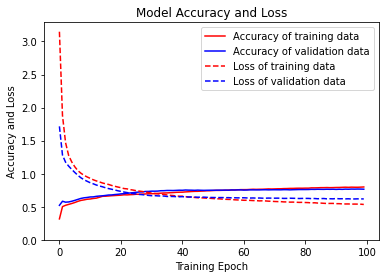

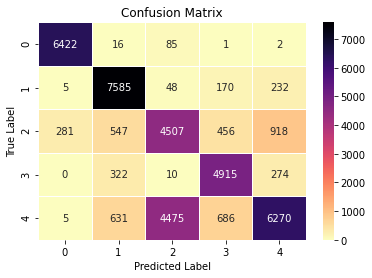

In [31]:
evaluation_history = model.evaluate(
            [X_test, X_test_stats], y_test, batch_size=128, verbose=1)
save_test_history(evaluation_history, OVERLAP_PERCENT)
save_accuracy_loss_figure(history, OVERLAP_PERCENT)
validations, predictions = compute_validations_predictions_with_stats(
    model, X_test, y_test, X_test_stats)
save_confusion_matrix_figure(
    validations, predictions, OVERLAP_PERCENT, sns)

In [27]:
print(X_train.shape)
print(X_train_stats.shape)

(108973, 128, 12)
(108973, 12)


In [28]:
import tensorflow_model_optimization as tfmot


In [30]:
keras_model = model
model.summary()

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open('qauntized-model.tflite', 'wb').write(tflite_quant_model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 128, 12, 4)   52          ['input_3[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 12, 4)  16          ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                            

INFO:tensorflow:Assets written to: /tmp/tmp9zg89khf/assets


19760

In [11]:
import random

# random integer from 0 to 9
def get_random_int():
    return random.randint(0, 113210)
randomIdx = get_random_int()
x_rand = X[randomIdx]
print(x_rand.shape)
x_rand = x_rand.reshape(-1, x_rand.shape[0], x_rand.shape[1], 1)
print(x_rand.shape)


(128, 12)
(1, 128, 12, 1)


In [12]:
X_train_reshape = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1).astype(np.float32)
representative_dataset = X_train_reshape.astype(np.float32)
representative_stat_dataset = X_train_stats.astype(np.float32)

def representative_dataset_gen():
    for _ in range(100):
        randomIdx = get_random_int();
        data1 = np.array(representative_dataset[randomIdx])
        data1 = data1.reshape(-1, data1.shape[0], data1.shape[1], 1)
        data2 = np.array(representative_stat_dataset[randomIdx])
        data2 = data2.reshape(-1, data2.shape[0])
        yield [data1, data2]

In [32]:
keras_model = model
model.summary()

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open('float-quantized-model.tflite', 'wb').write(tflite_quant_model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 12, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 128, 12, 4)   52          ['input_3[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 12, 4)  16          ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                            

INFO:tensorflow:Assets written to: /tmp/tmpv3g_p4qy/assets


36528

In [34]:
interpreter = tf.lite.Interpreter(model_path=str('float-quantized-model.tflite'))
interpreter.allocate_tensors()


In [75]:
X_train_reshape = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1).astype(np.float32)
print(X_train_reshape.shape)
X_tensor = np.array([X_train_reshape[9000]]).astype(np.float32)
X_stat_tensor = np.array([X_train_stats[9000]]).astype(np.float32)
print(interpreter.get_input_details())

input_details = interpreter.get_input_details()
print('\n',interpreter.get_output_details(), '\n')
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_details[0]['index'], X_stat_tensor)
interpreter.set_tensor(input_details[1]['index'], X_tensor)

interpreter.invoke()
predictions = interpreter.get_tensor(output_index)


(108973, 128, 12, 1)
[{'name': 'serving_default_input_4:0', 'index': 0, 'shape': array([ 1, 12], dtype=int32), 'shape_signature': array([-1, 12], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_input_3:0', 'index': 1, 'shape': array([  1, 128,  12,   1], dtype=int32), 'shape_signature': array([ -1, 128,  12,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

 [{'name': 'StatefulPartitionedCall:0', 'index': 15, 'shape': array([1, 6], dtype=int32), 'shape_signature': array([-1,  6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': arra

In [73]:
print(np.argmax(predictions[0]))
print(y_train[9000])

3
[0. 0. 0. 1. 0. 0.]


INFO:tensorflow:Assets written to: /tmp/tmplyne7abx/assets


INFO:tensorflow:Assets written to: /tmp/tmplyne7abx/assets


INFO:tensorflow:Assets written to: /tmp/tmpz_tu5v0w/assets


INFO:tensorflow:Assets written to: /tmp/tmpz_tu5v0w/assets
/home/sanjeev/.local/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


RuntimeError: tensorflow/lite/kernels/conv.cc:346 input->dims->size != 4 (2 != 4)Node number 0 (CONV_2D) failed to prepare.

In [25]:
interpreter = tf.lite.Interpreter(model_path=str('./notebooks/optimized_model.tflite'))

ValueError: Could not open './notebooks/optimized_model.tflite'.